In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# dev train loop + model for respeller

# command line args

In [109]:
# imitate CLAs
import sys
sys.argv = [
    'train.py',
    '--fastpitch-chkpt', 'fastpitch/exps/test_addspaces_1_eos_dollar/FastPitch_checkpoint_50.pt',
    '--input-type', 'char',
    '--symbol-set', 'english_basic_lowercase',
    '--use-mas',
    '--cuda',
    '--n-speakers', '1',
    '--use-sepconv',
    '--add-spaces',
    '--eos-symbol', '$',
    '--epochs', '1', # for development!
    '--chkpt-save-dir', '/home/s1785140/respeller/exps/test', 
]

# Imports

In [110]:
'''
Train respeller model

We backpropagate loss from pretrained TTS model to a Grapheme-to-Grapheme (G2G) respeller model to help it respell words
into a simpler form

Intermediated respellings are discrete character sequences
We can backpropagate through these using gumbel softmax and the straight through estimator
'''
import argparse
import numpy as np
import torch
import torch.distributed as dist
import torch.nn.functional as F
import json

from fastpitch import models as fastpitch_model
from fastpitch.common.text.text_processing import TextProcessor

from modules.model import EncoderRespeller
from modules.gumbel_vector_quantizer import GumbelVectorQuantizer
from modules.sdtw_cuda_loss import SoftDTW

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Functions

## arguments to parse

In [111]:
def parse_args(parser):
    """Parse commandline arguments"""
    parser.add_argument('-o', '--chkpt-save-dir', type=str, required=True,
                        help='Directory to save checkpoints')
    parser.add_argument('-d', '--dataset-path', type=str, default='./',
                        help='Path to dataset')
    parser.add_argument('--log-file', type=str, default=None,
                        help='Path to a DLLogger log file')

    train_args = parser.add_argument_group('training setup')
    train_args.add_argument('--cuda', action='store_true',
                      help='Enable GPU training')
    train_args.add_argument('--batch-size', type=int, default=16,
                      help='Batchsize (this is divided by number of GPUs if running Data Distributed Parallel Training)')
    train_args.add_argument('--seed', type=int, default=1337,
                       help='Seed for PyTorch random number generators')
    train_args.add_argument('--grad-accumulation', type=int, default=1,
                       help='Training steps to accumulate gradients for')
    train_args.add_argument('--epochs', type=int, default=100, #required=True,
                       help='Number of total epochs to run')
    train_args.add_argument('--epochs-per-checkpoint', type=int, default=10,
                       help='Number of epochs per checkpoint')
    train_args.add_argument('--checkpoint-path', type=str, default=None,
                       help='Checkpoint path to resume train')
    train_args.add_argument('--resume', action='store_true',
                       help='Resume train from the last available checkpoint')
    
    opt_args = parser.add_argument_group('optimization setup')
    opt_args.add_argument('--optimizer', type=str, default='lamb', choices=['adam', 'lamb'],
                     help='Optimization algorithm')
    opt_args.add_argument('-lr', '--learning-rate', default=0.1, type=float,
                     help='Learning rate')
    opt_args.add_argument('--weight-decay', default=1e-6, type=float,
                     help='Weight decay')
    # opt_args.add_argument('--grad-clip-thresh', default=1000.0, type=float,
    #                  help='Clip threshold for gradients')
    opt_args.add_argument('--warmup-steps', type=int, default=1000,
                     help='Number of steps for lr warmup')

    data_args = parser.add_argument_group('dataset parameters')
    cond_args = parser.add_argument_group('conditioning on additional attributes')
    audio_args = parser.add_argument_group('log generated audio')
    dist_args = parser.add_argument_group('distributed training setup')

    arch_args = parser.add_argument_group('architecture')
    arch_args.add_argument('--d-model', type=int, default=512,
                       help='Hidden dimension of tranformer')
    arch_args.add_argument('--latent-temp', type=tuple, default=(2, 0.5, 0.999995),
                       help='Temperature annealling parameters for Gumbel-Softmax (start, end, decay)')

    pretrained_tts_args = parser.add_argument_group('pretrained tts model')
    # pretrained_tts_args.add_argument('--fastpitch-with-mas', type=bool, default=True,
    #                   help='Whether or not fastpitch was trained with Monotonic Alignment Search (MAS)')
    pretrained_tts_args.add_argument('--fastpitch-chkpt', type=str, required=True,
                      help='Path to pretrained fastpitch checkpoint')
    pretrained_tts_args.add_argument('--input-type', type=str, default='char',
                      choices=['char', 'phone', 'pf', 'unit'],
                      help='Input symbols used, either char (text), phone, pf '
                      '(phonological feature vectors) or unit (quantized acoustic '
                      'representation IDs)')
    pretrained_tts_args.add_argument('--symbol-set', type=str, default='english_basic_lowercase',
                      help='Define symbol set for input sequences. For quantized '
                      'unit inputs, pass the size of the vocabulary.')
    pretrained_tts_args.add_argument('--n-speakers', type=int, default=1,
                      help='Condition on speaker, value > 1 enables trainable '
                      'speaker embeddings.')
    # pretrained_tts_args.add_argument('--use-sepconv', type=bool, default=True,
    #                   help='Use depthwise separable convolutions')

    return parser

def load_checkpoint(args, model, filepath):
    if args.local_rank == 0:
        print(f'Loading model and optimizer state from {filepath}')
    checkpoint = torch.load(filepath, map_location='cpu')
    sd = {k.replace('module.', ''): v
          for k, v in checkpoint['state_dict'].items()}
    getattr(model, 'module', model).load_state_dict(sd)
    return model

def freeze_weights(model):
    # NB wait... won't this stop backprop of gradients?
    # We just don't want to add the fastpitch/quantiser model weights to the optimiser...
    for param in model.parameters():
        param.requires_grad = False

def init_embedding_weights(source_tensor, target_tensor):
    """copy weights inplace from source tensor to target tensor"""
    target_tensor.requires_grad = False
    target_tensor.copy_(source_tensor.clone().detach())
    target_tensor.requires_grad = True

def load_pretrained_fastpitch(args):
    # load chkpt
    device = torch.device('cuda' if args.cuda else 'cpu')
    model_config = fastpitch_model.get_model_config('FastPitch', args)
    fastpitch = fastpitch_model.get_model('FastPitch', model_config, device, forward_is_infer=True)
    load_checkpoint(args, fastpitch, args.fastpitch_chkpt)
    # get information about grapheme embedding table
    n_symbols = fastpitch.encoder.word_emb.weight.size(0)
    grapheme_embedding_dim = fastpitch.encoder.word_emb.weight.size(1)
    return fastpitch, n_symbols, grapheme_embedding_dim

# beginning of main(), parse Command Line Args

In [112]:
parser = argparse.ArgumentParser(description='PyTorch Respeller Training', allow_abbrev=False)
parser = parse_args(parser)
args, _unk_args = parser.parse_known_args()

parser = fastpitch_model.parse_model_args('FastPitch', parser)
args, unk_args = parser.parse_known_args()
if len(unk_args) > 0:
    raise ValueError(f'Invalid options {unk_args}')

if args.cuda:
    args.num_gpus = torch.cuda.device_count()
    args.distributed_run = args.num_gpus > 1
    args.batch_size = int(args.batch_size / args.num_gpus)
else:
    args.distributed_run = False

torch.manual_seed(args.seed)
np.random.seed(args.seed)

if args.distributed_run:
    mp.spawn(train, nprocs=args.num_gpus, args=(args,))

# 'train()' - forward pass through model to get loss

## create / load models 

In [72]:
rank = 0
device = 'cuda'

args.local_rank = rank
tts, n_symbols, grapheme_embedding_dim = load_pretrained_fastpitch(args)
tts.to(device)

respeller = EncoderRespeller(n_symbols=n_symbols, d_model=args.d_model)
respeller.to(device)

quantiser = GumbelVectorQuantizer(
    in_dim=args.d_model,
    codebook_size=n_symbols,  # number of codebook entries
    embedding_dim=grapheme_embedding_dim,
    temp=args.latent_temp,
)
quantiser.to(device)

init_embedding_weights(tts.encoder.word_emb.weight.unsqueeze(0), quantiser.vars)

# batch_size, len_x, len_y, dims = 8, 15, 12, 5
# x = torch.rand((batch_size, len_x, dims), requires_grad=True)
# y = torch.rand((batch_size, len_y, dims))

# criterion = SoftDTW(use_cuda=True, gamma=0.1, dist_func=F.mse_loss)
criterion = SoftDTW(use_cuda=True, gamma=0.1)
# input should be size [bsz, seqlen, dim]
criterion.to(device)

Loading model and optimizer state from fastpitch/exps/test_addspaces_1_eos_dollar/FastPitch_checkpoint_50.pt


SoftDTW()

In [8]:
# skip_emb(fastpitch)

# if args.respeller_loss:
#     respelling_loss_fn = CrossEntropy()
# else:

## forward pass through model with dummy data

In [9]:
batches = []
symbol_set = 'english_basic_lowercase'
text_cleaners = []
gt_log_mel = torch.load('/home/s1785140/data/ljspeech_fastpitch/mels/LJ001-0001.pt').cuda().unsqueeze(0).transpose(1,2) # intro batch dimension + [bsz, seqlen, dim]
raw_text = 'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'

# process text using same processor as fastpitch
tp = TextProcessor(symbol_set, text_cleaners)
text = torch.LongTensor(tp.encode_text(raw_text)).unsqueeze(0).cuda()

batches.append((text, gt_log_mel))

In [10]:
text.size()

torch.Size([1, 151])

In [11]:
text.device

device(type='cuda', index=0)

In [12]:
# for batch in batches:
batch = batches[0]
    
###############################################################################################################
# text, ssl_reps, e2e_asr_predictions, gt_log_mel = batch
text, gt_log_mel = batch

###############################################################################################################
# create inputs
# if args.use_acoustic_input:
#     inputs = inputs.concat(ssl_reps)

###############################################################################################################
# forward pass
logits = respeller(text[:13])
logits.size()

1: before embed inputs.size()=torch.Size([1, 151])
2: after embed inputs.size()=torch.Size([1, 151, 512])
3: after pos encoder inputs.size()=torch.Size([1, 151, 512])
4: after ff transformer logits.size()=torch.Size([1, 151, 512])


torch.Size([1, 151, 512])

In [13]:
n_symbols

124

In [14]:
logits.device

device(type='cuda', index=0)

In [15]:
g_embedding_indices = quantiser(logits, produce_targets=True)["targets"].squeeze(2)

In [16]:
g_embedding_indices.size()

torch.Size([1, 151])

In [17]:
g_embeddings = quantiser(logits, produce_targets=False)["x"]

In [18]:
g_embeddings.size()

torch.Size([1, 151, 384])

In [19]:
padding_idx = 0
mask = (g_embedding_indices != padding_idx).unsqueeze(2)
mask.size()

torch.Size([1, 151, 1])

In [20]:
log_mel, dec_lens, _dur_pred, _pitch_pred = tts(g_embeddings, skip_embeddings=True, ids=g_embedding_indices)
# log_mel [bsz, dim, seqlen]
log_mel = log_mel.transpose(1,2)
# log_mel [bsz, seqlen, dim]

print(f'{log_mel.size()=}')
print(f'{gt_log_mel.size()=}')

###############################################################################################################
# calculate losses
# respelling_loss = respelling_loss_fn(respelling, e2e_asr_predictions)
acoustic_loss = criterion(log_mel, gt_log_mel)

# average loss over frames 
acoustic_loss = acoustic_loss / dec_lens
# mel_loss = (mel_loss * mel_mask).sum() / mel_mask.sum()

###############################################################################################################
# backward pass
loss = acoustic_loss 

print(f'{loss=}')

# loss.backward()

###############################################################################################################
# log tensorboard metrics

###############################################################################################################
# validation set evaluation

log_mel.size()=torch.Size([1, 878, 80])
gt_log_mel.size()=torch.Size([1, 832, 80])
x.size()=torch.Size([1, 878, 832, 80])
y.size()=torch.Size([1, 878, 832, 80])
loss=tensor([234.9162], device='cuda:0', grad_fn=<DivBackward0>)


In [21]:
def plot_spectrogram(log_mel, batch_index):
    print(f'{log_mel[batch_index].transpose(0,1).size()=}')
    log_mel = log_mel[batch_index].transpose(0,1).detach().cpu().numpy()

    plt.figure(figsize=(15,5))
    librosa.display.specshow(log_mel, x_axis='frames', y_axis='linear')
    plt.colorbar()

log_mel[batch_index].transpose(0,1).size()=torch.Size([80, 878])


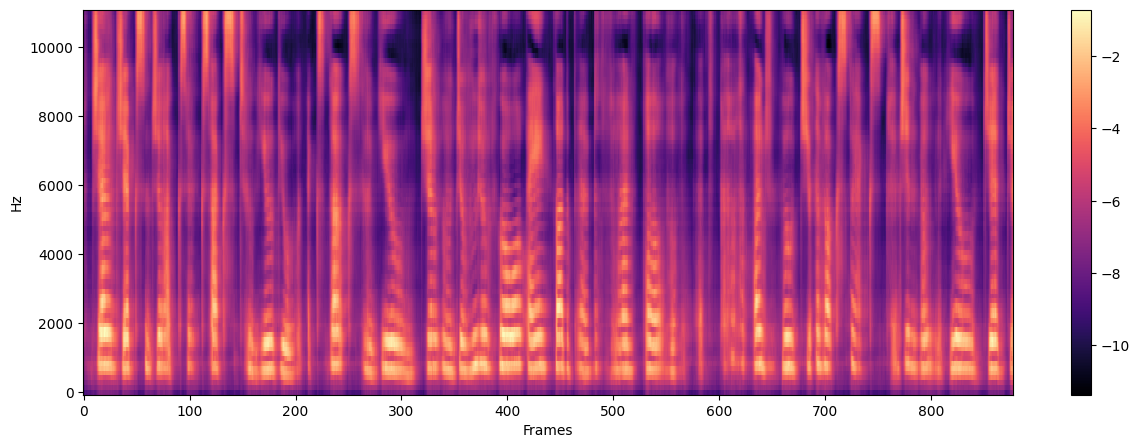

In [22]:
plot_spectrogram(log_mel, batch_index=0)

log_mel[batch_index].transpose(0,1).size()=torch.Size([80, 832])


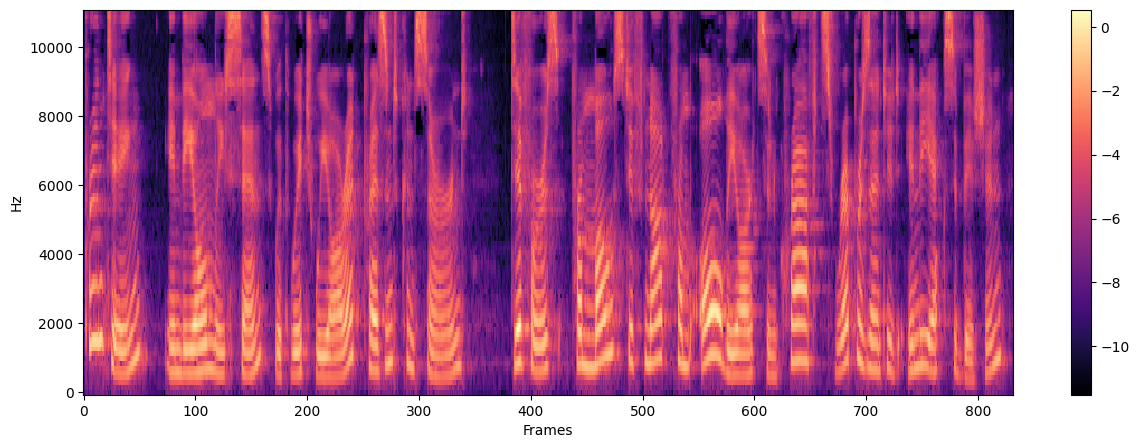

In [23]:
plot_spectrogram(gt_log_mel, batch_index=0)

# develop respeller dataset

In [24]:
import torch
import os
from collections import Counter
from tqdm import tqdm

In [25]:
wordaligned_speechreps_dir = '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels' # path to directory that contains folders of word aligned speech reps
wordlist = ['identifies','mash','player','russias','techniques'] # txt file for the words to include speech reps 

In [26]:
token_and_melfilepaths = []
for word in wordlist:
    # find all word aligned mels for the word
    word_dir = os.path.join(wordaligned_speechreps_dir, word)
    mel_files = os.listdir(word_dir)
    for mel_file in mel_files:
        mel_file_path = os.path.join(word_dir, mel_file)
        token_and_melfilepaths.append((word, mel_file_path))
    

In [27]:
token_and_melfilepaths

[('identifies',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/identifies/identifies__LJ040-0003__occ1__seqlen68.pt'),
 ('mash',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/mash/mash__LJ020-0011__occ1__seqlen28.pt'),
 ('player',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/player/player__LJ041-0014__occ1__seqlen49.pt'),
 ('russias',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/russias/russias__LJ042-0204__occ1__seqlen38.pt'),
 ('techniques',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/techniques/techniques__LJ046-0157__occ1__seqlen73.pt'),
 ('techniques',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/techniques/techniques__LJ050-0196__occ1__seqlen59.pt')]

## process text

In [28]:
from fastpitch.common.text.text_processing import TextProcessor
text_cleaners = []
symbol_set = "english_basic_lowercase_no_arpabet"
tp = TextProcessor(symbol_set, text_cleaners, add_spaces=True, eos_symbol="$")

In [29]:
encoded = torch.IntTensor(tp.encode_text('identifies'))
encoded

tensor([12, 21, 16, 17, 26, 32, 21, 18, 21, 17, 31, 39], dtype=torch.int32)

In [30]:
decoded = [tp.id_to_symbol[id] for id in encoded.tolist()]
decoded

[' ', 'i', 'd', 'e', 'n', 't', 'i', 'f', 'i', 'e', 's', '$']

## process mel

In [31]:
word, fp = token_and_melfilepaths[0]
wordaligned_mel = torch.load(fp)
wordaligned_mel.size() # [seqlen, feats]

torch.Size([68, 80])

## 'class'-ified dataset class

In [32]:
from fastpitch.common.text.text_processing import TextProcessor

class RespellerDataset(torch.utils.data.Dataset):
    """
        1) loads word + word-aligned mel spec for all words in a wordlist
        2) converts text to sequences of one-hot vectors (corresponding to grapheme indices in fastpitch)
    """
    def __init__(
        self, 
        wordaligned_speechreps_dir, # path to directory that contains folders of word aligned speech reps
        wordlist, # txt file for the words to include speech reps from
        max_examples_per_wordtype=None,
        text_cleaners=[],
        symbol_set="english_basic_lowercase_no_arpabet",
        add_spaces=True,
        eos_symbol="$",
        **kwargs,
    ):
        # load wordlist as a python list
        if type(wordlist) == str:
            if wordlist.endswith('.json'):
                with open(wordlist) as f:
                    wordlist = json.load(f)
            else:
                with open(wordlist) as f:
                    wordlist = f.read().splitlines()
        elif type(wordlist) == list:
            pass # dont need to do anything, already in expected form
        elif type(wordlist) == set:
            wordlist = list(wordlist)
        
        wordlist = sorted(wordlist)
        
        # create list of all word tokens and their word aligned speech reps
        self.word_freq = Counter()
        self.token_and_melfilepaths = []
        print("Initialising respeller dataset")
        for word in tqdm(wordlist):
            # find all word aligned mels for the word
            word_dir = os.path.join(wordaligned_speechreps_dir, word)
            mel_files = os.listdir(word_dir)
            if max_examples_per_wordtype:
                mel_files = mel_files[:max_examples_per_wordtype]
            for mel_file in mel_files:
                mel_file_path = os.path.join(word_dir, mel_file)
                self.token_and_melfilepaths.append((word, mel_file_path))
                self.word_freq[word] += 1
                
        self.tp = TextProcessor(symbol_set, text_cleaners, add_spaces=add_spaces, eos_symbol=eos_symbol)

    def get_mel(self, filename):
        return torch.load(filename)

    def encode_text(self, text):
        """encode raw text into indices defined by grapheme embedding table of the TTS model"""
        return torch.IntTensor(self.tp.encode_text(text))
    
    def decode_text(self, encoded):
        return [self.tp.id_to_symbol[id] for id in encoded.tolist()]

    def __getitem__(self, index):
        word, mel_filepath = self.token_and_melfilepaths[index]
        encoded_word = self.encode_text(word)
        mel = self.get_mel(mel_filepath)
        
        return {
            'word': word, 
            'encoded_word': encoded_word, 
            'mel': mel,
        }

    def __len__(self):
        return len(self.token_and_melfilepaths)

In [33]:
dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist=['identifies','mash','player','russias','techniques'],
)

Initialising respeller dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2588.44it/s]


In [34]:
batch = []

for itemdict in dataset:
    # unpack dict
    word = itemdict['word'] 
    encoded_word = itemdict['encoded_word'] 
    mel = itemdict['mel'] 
    
    # check
    print(word, encoded_word, mel.size())
    
    batch.append(itemdict)

identifies tensor([12, 21, 16, 17, 26, 32, 21, 18, 21, 17, 31, 39], dtype=torch.int32) torch.Size([68, 80])
mash tensor([12, 25, 13, 31, 20, 39], dtype=torch.int32) torch.Size([28, 80])
player tensor([12, 28, 24, 13, 37, 17, 30, 39], dtype=torch.int32) torch.Size([49, 80])
russias tensor([12, 30, 33, 31, 31, 21, 13, 31, 39], dtype=torch.int32) torch.Size([38, 80])
techniques tensor([12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39], dtype=torch.int32) torch.Size([73, 80])
techniques tensor([12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39], dtype=torch.int32) torch.Size([59, 80])


## collate function

In [35]:
class Collate():
    """ Zero-pads model inputs and targets based on number of frames per setep
    """
    # def __init__(self):
    
    def __call__(self, batch):
        """Collate's training batch from encoded word token and its 
        corresponding word-aligned mel spectrogram
        
        batch: [encoded_token, wordaligned_mel]
        """
        # Right zero-pad all one-hot text sequences to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(x['encoded_word']) for x in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]

        words = []
        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()
        text_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            words.append(batch[ids_sorted_decreasing[i]]['word'])
            text = batch[ids_sorted_decreasing[i]]['encoded_word']
            text_padded[i, :text.size(0)] = text
            text_lengths[i] = text.size(0)

        # Right zero-pad mel-spec
        num_mels = batch[0]['mel'].size(1)
        max_target_len = max([x['mel'].size(0) for x in batch])

        mel_padded = torch.FloatTensor(len(batch), max_target_len, num_mels)
        mel_padded.zero_()
        mel_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]]['mel']
            mel_padded[i, :mel.size(0), :] = mel
            mel_lengths[i] = mel.size(0)

        return {
            'words': words,
            'text_padded': text_padded,
            'text_lengths': text_lengths,
            'mel_padded': mel_padded, 
            'mel_lengths': mel_lengths,
        }
                # input_lengths, mel_padded, output_lengths,
                # len_x, dur_padded, dur_lens, pitch_padded, speaker)

In [36]:
collate_fn = Collate()
collated = collate_fn(batch)

In [37]:
collated['text_padded'].size()

torch.Size([6, 12])

In [38]:
collated['text_padded']

tensor([[12, 21, 16, 17, 26, 32, 21, 18, 21, 17, 31, 39],
        [12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39],
        [12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39],
        [12, 30, 33, 31, 31, 21, 13, 31, 39,  0,  0,  0],
        [12, 28, 24, 13, 37, 17, 30, 39,  0,  0,  0,  0],
        [12, 25, 13, 31, 20, 39,  0,  0,  0,  0,  0,  0]])

In [39]:
collated['words']

['identifies', 'techniques', 'techniques', 'russias', 'player', 'mash']

In [40]:
collated['mel_padded'].size()

torch.Size([6, 73, 80])

## put batch on gpu

In [41]:
def to_gpu(x):
    x = x.contiguous()
    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def batch_to_gpu(collated_batch):
    """put elements that are used throughout training onto gpu"""
    words = collated_batch['words']
    text_padded = collated_batch['text_padded']
    text_lengths = collated_batch['text_lengths']
    mel_padded = collated_batch['mel_padded']
    mel_lengths = collated_batch['mel_lengths']
    
    # no need to put words on gpu, its only used during eval loop
    text_padded = to_gpu(text_padded).long()
    text_lengths = to_gpu(text_lengths).long()
    mel_padded = to_gpu(mel_padded).float()
    mel_lengths = to_gpu(mel_lengths).long()
    
    # x: inputs
    x = {
        'words': words,
        'text_padded': text_padded,
        'text_lengths': text_lengths,
    }
    # y: targets
    y = {
        'mel_padded': mel_padded, 
        'mel_lengths': mel_lengths,
    }
    
    return (x, y)

In [42]:
# batch_to_gpu(collated)

# full train + dev datasets

In [43]:
train_dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist='/home/s1785140/data/ljspeech_fastpitch/respeller_train_words.json',
    max_examples_per_wordtype=2,
)

Initialising respeller dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7479/7479 [00:42<00:00, 176.40it/s]


In [44]:
len(train_dataset)

10363

In [45]:
sum(train_dataset.word_freq.values())

10363

In [46]:
dev_dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist='/home/s1785140/data/ljspeech_fastpitch/respeller_dev_words.json',
)

Initialising respeller dataset


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 415/415 [00:00<00:00, 547.83it/s]


In [47]:
len(dev_dataset)

415

In [48]:
sum(dev_dataset.word_freq.values())

415

# create torch dataloader

In [49]:
from torch.utils.data import DataLoader

In [50]:
# TODO, implement distributed training?
train_sampler = None
shuffle = True
num_cpus = 1 
train_loader = DataLoader(train_dataset, num_workers=2*num_cpus, shuffle=shuffle,
                          sampler=train_sampler, batch_size=args.batch_size,
                          pin_memory=False, drop_last=True,
                          collate_fn=collate_fn)

In [51]:
# for batch in train_loader:
#     print(batch)

# FULL train() loop

## imports

In [123]:
from torch_optimizer import Lamb
import time

## functions

In [124]:
def adjust_learning_rate(total_iter, opt, learning_rate, warmup_iters=None):
    if warmup_iters == 0:
        scale = 1.0
    elif total_iter > warmup_iters:
        scale = 1. / (total_iter ** 0.5)
    else:
        scale = total_iter / (warmup_iters ** 1.5)

    for param_group in opt.param_groups:
        param_group['lr'] = learning_rate * scale

## pre-training loop stuff

In [125]:
# def train(rank, args):


# handle GPU
rank = 0
args.local_rank = rank
device = torch.device('cuda' if args.cuda else 'cpu')

# load models
tts, n_symbols, grapheme_embedding_dim = load_pretrained_fastpitch(args)
respeller = EncoderRespeller(n_symbols=n_symbols, d_model=args.d_model)
quantiser = GumbelVectorQuantizer(
    in_dim=args.d_model,
    codebook_size=n_symbols,  # number of codebook entries
    embedding_dim=grapheme_embedding_dim,
    temp=args.latent_temp,
)
init_embedding_weights(tts.encoder.word_emb.weight.unsqueeze(0), quantiser.vars)
criterion = SoftDTW(use_cuda=True, gamma=0.1) # input should be size [bsz, seqlen, dim]

tts.to(device)
respeller.to(device)
quantiser.to(device)
criterion.to(device)

# load optimiser and assign to it the weights to be trained
kw = dict(lr=args.learning_rate, betas=(0.9, 0.98), eps=1e-9,
          weight_decay=args.weight_decay)
optimizer = Lamb(list(respeller.parameters()) + list(quantiser.trainable_parameters()), **kw)

# (optional) load checkpoint for respeller
start_epoch = [1]
start_iter = [0]
assert args.checkpoint_path is None or args.resume is False, (
    "Specify a single checkpoint source")
if args.checkpoint_path is not None:
    ch_fpath = args.checkpoint_path
elif args.resume:
    ch_fpath = last_checkpoint(args.chkpt_save_dir)
else:
    ch_fpath = None
if ch_fpath is not None:
    load_checkpoint(args, respeller, ema_model, optimizer, scaler,
                    start_epoch, start_iter, model_config, ch_fpath)
start_epoch = start_epoch[0]
total_iter = start_iter[0]
    
# create datasets, collate func, dataloader
train_dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist='/home/s1785140/data/ljspeech_fastpitch/respeller_train_words.json',
    max_examples_per_wordtype=2,
)
dev_dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist='/home/s1785140/data/ljspeech_fastpitch/respeller_dev_words.json',
)
num_cpus = 1 # TODO change to CLA?
train_loader = DataLoader(train_dataset, num_workers=2*num_cpus, shuffle=True,
                          sampler=None, batch_size=args.batch_size,
                          pin_memory=False, drop_last=True,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, num_workers=2*num_cpus, shuffle=False,
                          sampler=None, batch_size=args.batch_size,
                          pin_memory=False, collate_fn=collate_fn)

# load pretrained hifigan

# log spectrograms and generated audio for first few validation wordtypes

# train loop
respeller.train()
quantiser.train()
_ = tts.eval()

Loading model and optimizer state from fastpitch/exps/test_addspaces_1_eos_dollar/FastPitch_checkpoint_50.pt


## train loop

In [135]:
from fastpitch.common.utils import mask_from_lens
import fastpitch.common.tb_dllogger as logger
from collections import OrderedDict

# initialise logger
tb_subsets = ['train', 'val']
log_fpath = args.log_file or os.path.join(args.chkpt_save_dir, 'nvlog.json')
touch_file(log_fpath)

logger.init(log_fpath, args.chkpt_save_dir, enabled=(args.local_rank == 0),
            tb_subsets=tb_subsets)
logger.parameters(vars(args), tb_subset='train')

DLLLoggerAlreadyInitialized: 

In [136]:
def forward_pass(respeller, tts, x):
    """x: inputs
    x = {
        'words': words,
        'text_padded': text_padded,
        'text_lengths': text_lengths,
    }"""
    logits = respeller(x['text_padded'])
    
    quantiser_outdict = quantiser(logits, produce_targets=True)
    g_embedding_indices = quantiser_outdict["targets"].squeeze(2)
    g_embeddings = quantiser_outdict["x"]

    log_mel, dec_lens, _dur_pred, _pitch_pred = tts(
        inputs=g_embeddings,
        ids=g_embedding_indices,
        skip_embeddings=True,
    )
    
    # log_mel: [bsz, dim, seqlen]
    log_mel = log_mel.transpose(1,2)
    # log_mel: [bsz, seqlen, dim]
    
    # return mask for masking acoustic loss
    # padding_idx = 0
    # mask = (g_embedding_indices != padding_idx).unsqueeze(2)
    # mask.size()
    # dec_mask = mask_from_lens(dec_lens).unsqueeze(2)
    
    return log_mel, dec_lens

In [137]:
def log_stdout(logger, subset, epoch_iters, total_steps, loss, took):
    logger_data = [
        ('Loss/Total', loss),
    ]
    logger_data.append(('Time/Iter time', took))
    logger.log(epoch_iters,
               tb_total_steps=total_steps,
               subset=subset,
               data=OrderedDict(logger_data)
    )

In [138]:
def touch_file(path):
    if not os.path.exists(path):
        basedir = os.path.dirname(path)
        os.makedirs(basedir, exist_ok=True)
        with open(path, 'w') as f:
            f.write("")

In [142]:
for epoch in range(start_epoch, args.epochs + 1):
    # logging metrics
    epoch_start_time = time.perf_counter()
    epoch_loss = 0.0
    epoch_mel_loss = 0.0
    epoch_num_frames = 0
    epoch_frames_per_sec = 0.0
    iter_loss = 0
    iter_num_frames = 0
    iter_meta = {}
    epoch_iter = 0
    num_iters = len(train_loader)
    
    print("debug, epoch", epoch)

    # iterate over all batches in epoch
    for batch in train_loader:        
        if epoch_iter == 1:
            break # NB quit training loop, FOR DEVELOPMENT!!!
        
        if epoch_iter == num_iters: # useful for gradient accumulation
            break
            
        print("debug, epoch_iter", epoch_iter)
                    
        total_iter += 1
        epoch_iter += 1
        iter_start_time = time.perf_counter()

        adjust_learning_rate(total_iter, optimizer, args.learning_rate,
                             args.warmup_steps)

        respeller.zero_grad()
        quantiser.zero_grad()

        x, y = batch_to_gpu(batch) # x: inputs, y: targets
        gt_mel = y["mel_padded"]
        
        # # y: targets
        # y = {
        #     'mel_padded': mel_padded, 
        #     'mel_lengths': mel_lengths,
        # }
        
        # forward pass through models (respeller -> quantiser -> tts)
        pred_mel, dec_lens = forward_pass(respeller, tts, x)
        
        print(f'{pred_mel.size()=}')
        print(f'{gt_mel.size()=}')
        
        # TODO: DO WE NEED MASK IF WE USE SOFTDTW LOSS? 
        # I THINK IT AUTOMATICALLY WILL ALIGN PADDED FRAMES WITH EACH OTHER???
        
        # calculate loss
        loss = criterion(pred_mel, gt_mel)
        print('raw loss from softdtw', loss)
        
        loss = loss / dec_lens
        print('loss avg according to dec seqlens', loss)
        
        loss = loss.mean()
        print('loss avged across batch', loss)
        
        # backpropagation of loss
        loss.backward()
        
        # log metrics
        iter_loss += loss.item()
        iter_time = time.perf_counter() - iter_start_time
        epoch_loss += iter_loss
        
        log_stdout(
            logger,
            'train',
            (epoch, epoch_iter, num_iters),
            total_iter,
            iter_loss,
            iter_time,
        )
        
        def validate():
            pass
        
        validate()
        
        def maybe_save_checkpoint(args, model, optimizer, scaler, epoch,
                                  total_iter, config):
            if args.local_rank != 0:
                return

            intermediate = (args.epochs_per_checkpoint > 0
                            and epoch % args.epochs_per_checkpoint == 0)

            if not intermediate and epoch < args.epochs:
                return

            fpath = os.path.join(args.chkpt_save_dir, f"FastPitch_checkpoint_{epoch}.pt")
            print(f"Saving model and optimizer state at epoch {epoch} to {fpath}")
            checkpoint = {'epoch': epoch,
                          'iteration': total_iter,
                          'config': config,
                          'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict()}
            torch.save(checkpoint, fpath)
        
        maybe_save_checkpoint(args, respeller, optimizer, 
                              epoch, total_iter, model_config)
        
        logger.flush()
        
print("Finished training!")

print("Performing final validation")
log_stdout(
    logger,
    'train_avg',
    (),
    None,
    epoch_loss / epoch_iter,
    epoch_time,
)
validate()

debug, epoch 1
debug, epoch_iter 0
pred_mel.size()=torch.Size([16, 91, 80])
gt_mel.size()=torch.Size([16, 87, 80])
x.size()=torch.Size([16, 91, 87, 80])
y.size()=torch.Size([16, 91, 87, 80])
raw loss from softdtw tensor([123033.3047,  19809.4883,  10334.9072,  67419.7891,  27053.0918,
         18232.9336,  21361.1953,  15932.0781,  18020.6836,  23050.4609,
         12999.6982,  17123.5020,  14649.6797,  17058.2324,  15492.6152,
         27558.7832], device='cuda:0', grad_fn=<_SoftDTWCUDABackward>)
loss avg according to dec seqlens tensor([1732.8634,  295.6640,  169.4247,  740.8768,  307.4215,  272.1333,
         318.8238,  237.7922,  246.8587,  344.0367,  199.9954,  267.5547,
         232.5346,  240.2568,  218.2058,  316.7676], device='cuda:0',
       grad_fn=<DivBackward0>)
loss avged across batch tensor(383.8256, device='cuda:0', grad_fn=<MeanBackward0>)
DLL 2022-11-17 16:51:15 - epoch    1 | iter   1/647 | loss 383.83 | took 0.16 s


NameError: name 'model' is not defined